### 할당된 GPU 확인

In [ ]:
!nvidia-smi

Tue Jun 15 04:53:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

### 필요한 library 및 자료 다운로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 109kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 13.3MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595705 sha256=59b7cb049ccf4dae2b6378b865d4784e62ab0a535915afd7321bb9fc097cb962
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 11.3MB/s 
     |████████████████████████████████| 2.3MB 11.7MB/s 
     |████████████████████████████████| 3.3MB 44.6MB/s 
     |████████████████████████████████| 901kB 36.0MB/s 


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [ ]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [ ]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber.csv'

In [ ]:
df = pd.read_csv(file1)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'id', 'title', 'description', 'input', 'output', 'text', 'ner_decode',
       'list_ner', 'ner_preprocessed_desc', 'Mathematics',
       'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue', 'only_korean_desc',
       'only_korean_input', 'only_korean_output', 'only_korean_variable_desc',
       'only_korean_variablenumber_desc', 'only_korean_variablenumber_input',
       'only_korean_variablenumber_output', 'variablenumber_desc',
       'variablenumber_input', 'variablenumber_output',
       'desc_variabel_renumber', 'input_variabel_renumber',
       'output_variabel_renumber', 'desc_variabel_renumber_0',
       'input_variabel_renumber_0', 'output_varia

### 분류한 dataset을 형식에 맞게 변환하는 코드

In [ ]:
def set_data(dataframe) :
  dataset = []
  for index, row in df.iterrows():
    desc = row['desc_variabel_renumber_0']
    if not pd.isna(row['input_variabel_renumber_0']) :
       desc = desc + row['input_variabel_renumber_0'] 


    dataset.append([desc , 0])
  return dataset

In [ ]:
dataset = set_data(df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [ ]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [ ]:
## Setting parameters
max_len = 512
batch_size = 32
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 100

### 데이터 셋 표준화 과정

In [ ]:
data_all = BERTDataset(dataset, 0, 1, tok, max_len, True, False)

In [ ]:
dataloader = torch.utils.data.DataLoader(data_all, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        return pooler

### model 할당

In [ ]:
model = BERTClassifier(bertmodel, num_classes=18, dr_rate=0.1).to(device) 

In [ ]:
threshold = 0.5

In [ ]:
def calc_accuracy_multilabel(X,Y):
    N, C = Y.shape
    X[X >= threshold] = 1
    X[X < threshold] = 0
#    train_acc = accuracy_score(torch.tensor(Y).cpu(), torch.tensor(X).cpu(), normalize=False)
    train_acc = (X == Y).sum().data.cpu().numpy()/ (N * C)
    return train_acc

# vector 뽑아내는 단계

In [ ]:
output = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    output.extend(out.to('cpu').tolist())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
df['vector'] = output
#df.to_csv('/content/drive/MyDrive/problem_ner_multilabel_re_vector.csv', encoding='utf-8-sig')

In [ ]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5)

In [ ]:
target_name = ['Mathematics', 'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue']

In [ ]:
def set_data_vector(df) :
  dataset = []
  for index, row in df.iterrows():
    label = []
    for i in target_name :
      label.append(row[i])
    dataset.append([torch.tensor(row['vector']), np.array(label, dtype=np.int32)])
  return dataset

In [ ]:
dataset_train = set_data_vector(train_df)
dataset_valid = set_data_vector(valid_df)
dataset_test = set_data_vector(test_df)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=4)

### linear model

In [102]:
class Classifier(nn.Module):
    def __init__(self,
                 hidden_size = 768,
                 num_classes=8,
                 dr_rate=0.0):
       super(Classifier, self).__init__()
       self.second_size = 384
       self.third_size = 192


       self.linear_relu_stack = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
       )
       self.mp = nn.MaxPool1d(2, stride= 2)
       self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(self.second_size, self.second_size),
            nn.ReLU(),
            nn.Linear(self.second_size, self.second_size),
            nn.ReLU()
       )
       self.mp = nn.MaxPool1d(2, stride= 2)
       self.linear_relu_stack3 = nn.Sequential(
            nn.Linear(self.third_size, self.third_size),
            nn.ReLU(),
            nn.Linear(self.third_size, self.third_size),
            nn.ReLU()
       )

       self.classication = nn.Linear(self.third_size, num_classes)

    def forward(self, x) :
      out = self.linear_relu_stack(x)
      out = out.unsqueeze(1)
      out = self.mp(out).squeeze()
      out = self.linear_relu_stack2(out)
      out = out.unsqueeze(1)
      out = self.mp(out).squeeze()
      out = self.linear_relu_stack3(out)
      
      
      return self.classication(out)

In [103]:
net = Classifier(num_classes=18, dr_rate = 0.1).to(device) 

In [104]:
learning_rate =  1e-4
num_epochs = 50

In [105]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

In [106]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
#loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)
#loss_fn = nn.BCELoss()
loss_fn = nn.MultiLabelSoftMarginLoss()

In [107]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [108]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#학습

In [109]:
train_loss_values = []
validation_loss_values = [] 

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    net.train()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        vector = vector.to(device)
        label = label.long().to(device)
        out = net.forward(vector)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy_multilabel(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    net.eval()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(valid_dataloader)):
        vector = vector.float().to(device)
        label = label.long().to(device)
        out = net(vector)
        loss = loss_fn(out, label)
        
        validation_loss += loss.item() 
        out = torch.sigmoid(out)
        test_acc += calc_accuracy_multilabel(out, label)
    print("epoch {} validation acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


epoch 1 batch id 1 loss 0.6976803541183472 train acc 0.9045138888888888

epoch 1 train acc 0.905156946767001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 validation acc 0.5581414473684211


epoch 2 batch id 1 loss 0.6883800029754639 train acc 0.9045138888888888

epoch 2 train acc 0.905156946767001



epoch 2 validation acc 0.9069033260233919


epoch 3 batch id 1 loss 0.2853282690048218 train acc 0.9045138888888888

epoch 3 train acc 0.905156946767001



epoch 3 validation acc 0.9069033260233919


epoch 4 batch id 1 loss 0.2870619595050812 train acc 0.9045138888888888

epoch 4 train acc 0.905156946767001



epoch 4 validation acc 0.9069033260233919


epoch 5 batch id 1 loss 0.2875751256942749 train acc 0.9045138888888888

epoch 5 train acc 0.905156946767001



epoch 5 validation acc 0.9069033260233919


epoch 6 batch id 1 loss 0.2876608371734619 train acc 0.9045138888888888

epoch 6 train acc 0.905156946767001



epoch 6 validation acc 0.9069033260233919


epoch 7 batch id 1 loss 0.2871772050857544 train acc 0.9045138888888888

epoch 7 train acc 0.905156946767001



epoch 7 validation acc 0.9069033260233919


epoch 8 batch id 1 loss 0.2869086265563965 train acc 0.9045138888888888

epoch 8 train acc 0.905156946767001



epoch 8 validation acc 0.9069033260233919


epoch 9 batch id 1 loss 0.2868756651878357 train acc 0.9045138888888888

epoch 9 train acc 0.905156946767001



epoch 9 validation acc 0.9069033260233919


epoch 10 batch id 1 loss 0.28651532530784607 train acc 0.9045138888888888

epoch 10 train acc 0.905156946767001



epoch 10 validation acc 0.9069033260233919


epoch 11 batch id 1 loss 0.28638604283332825 train acc 0.9045138888888888

epoch 11 train acc 0.905156946767001



epoch 11 validation acc 0.9069033260233919


epoch 12 batch id 1 loss 0.2861734628677368 train acc 0.9045138888888888

epoch 12 train acc 0.905156946767001



epoch 12 validation acc 0.9069033260233919


epoch 13 batch id 1 loss 0.28578802943229675 train acc 0.9045138888888888

epoch 13 train acc 0.905156946767001



epoch 13 validation acc 0.9069033260233919


epoch 14 batch id 1 loss 0.2851748764514923 train acc 0.9045138888888888

epoch 14 train acc 0.905156946767001



epoch 14 validation acc 0.9069033260233919


epoch 15 batch id 1 loss 0.28376686573028564 train acc 0.9045138888888888

epoch 15 train acc 0.905156946767001



epoch 15 validation acc 0.9071363304093568


epoch 16 batch id 1 loss 0.2790997624397278 train acc 0.9045138888888888

epoch 16 train acc 0.9052135590858417



epoch 16 validation acc 0.9063002558479532


epoch 17 batch id 1 loss 0.27718275785446167 train acc 0.9045138888888888

epoch 17 train acc 0.905307912950576



epoch 17 validation acc 0.9065880847953217


epoch 18 batch id 1 loss 0.27379271388053894 train acc 0.9045138888888888

epoch 18 train acc 0.9053833960423632



epoch 18 validation acc 0.9062408625730993


epoch 19 batch id 1 loss 0.2714613080024719 train acc 0.9045138888888888

epoch 19 train acc 0.9054211375882568



epoch 19 validation acc 0.9064144736842105


epoch 20 batch id 1 loss 0.26978909969329834 train acc 0.9045138888888888

epoch 20 train acc 0.9054400083612038



epoch 20 validation acc 0.9064144736842105


epoch 21 batch id 1 loss 0.2684888243675232 train acc 0.9045138888888888

epoch 21 train acc 0.9055343622259381



epoch 21 validation acc 0.9065880847953215


epoch 22 batch id 1 loss 0.26744896173477173 train acc 0.9045138888888888

epoch 22 train acc 0.9056475868636192



epoch 22 validation acc 0.9065880847953215


epoch 23 batch id 1 loss 0.2664607763290405 train acc 0.9045138888888888

epoch 23 train acc 0.9057041991824599



epoch 23 validation acc 0.9067616959064327


epoch 24 batch id 1 loss 0.2658003866672516 train acc 0.9045138888888888

epoch 24 train acc 0.9057608115013005



epoch 24 validation acc 0.9068485014619883


epoch 25 batch id 1 loss 0.265036404132843 train acc 0.9045138888888888

epoch 25 train acc 0.9058362945930879



epoch 25 validation acc 0.90687591374269


epoch 26 batch id 1 loss 0.2645242214202881 train acc 0.9045138888888888

epoch 26 train acc 0.9058740361389817



epoch 26 validation acc 0.9070495248538011


epoch 27 batch id 1 loss 0.26415568590164185 train acc 0.90625

epoch 27 train acc 0.9059117776848753



epoch 27 validation acc 0.9072231359649123


epoch 28 batch id 1 loss 0.2638830840587616 train acc 0.90625

epoch 28 train acc 0.9059495192307692



epoch 28 validation acc 0.9073967470760234


epoch 29 batch id 1 loss 0.2636989951133728 train acc 0.90625

epoch 29 train acc 0.9060250023225567



epoch 29 validation acc 0.9073099415204678


epoch 30 batch id 1 loss 0.26354578137397766 train acc 0.90625

epoch 30 train acc 0.906025002322557



epoch 30 validation acc 0.9073967470760234


epoch 31 batch id 1 loss 0.26365381479263306 train acc 0.90625

epoch 31 train acc 0.9060627438684508



epoch 31 validation acc 0.907483552631579


epoch 32 batch id 1 loss 0.2639802396297455 train acc 0.90625

epoch 32 train acc 0.9061193561872912



epoch 32 validation acc 0.9077439692982455


epoch 33 batch id 1 loss 0.26408544182777405 train acc 0.90625

epoch 33 train acc 0.9061759685061317



epoch 33 validation acc 0.9079175804093568


epoch 34 batch id 1 loss 0.2641395330429077 train acc 0.90625

epoch 34 train acc 0.9062703223708659



epoch 34 validation acc 0.9078307748538013


epoch 35 batch id 1 loss 0.2638164460659027 train acc 0.90625

epoch 35 train acc 0.9062891931438127



epoch 35 validation acc 0.9077439692982457


epoch 36 batch id 1 loss 0.26330211758613586 train acc 0.90625

epoch 36 train acc 0.9062703223708659



epoch 36 validation acc 0.9077439692982455


epoch 37 batch id 1 loss 0.26281023025512695 train acc 0.90625

epoch 37 train acc 0.9063835470085471



epoch 37 validation acc 0.9077439692982455


epoch 38 batch id 1 loss 0.26228898763656616 train acc 0.90625

epoch 38 train acc 0.9064401593273874



epoch 38 validation acc 0.907483552631579


epoch 39 batch id 1 loss 0.2617940306663513 train acc 0.90625

epoch 39 train acc 0.906496771646228



epoch 39 validation acc 0.9073099415204678


epoch 40 batch id 1 loss 0.26146507263183594 train acc 0.90625

epoch 40 train acc 0.9064212885544407



epoch 40 validation acc 0.907483552631579


epoch 41 batch id 1 loss 0.26108649373054504 train acc 0.90625

epoch 41 train acc 0.9064590301003344



epoch 41 validation acc 0.9073099415204678


epoch 42 batch id 1 loss 0.26064032316207886 train acc 0.90625

epoch 42 train acc 0.9064212885544406



epoch 42 validation acc 0.9077439692982457


epoch 43 batch id 1 loss 0.2601574659347534 train acc 0.90625

epoch 43 train acc 0.9063835470085467



epoch 43 validation acc 0.9077439692982455


epoch 44 batch id 1 loss 0.25986164808273315 train acc 0.90625

epoch 44 train acc 0.9064212885544404



epoch 44 validation acc 0.9077439692982455


epoch 45 batch id 1 loss 0.25975608825683594 train acc 0.90625

epoch 45 train acc 0.9063835470085466



epoch 45 validation acc 0.9077439692982455


epoch 46 batch id 1 loss 0.25972944498062134 train acc 0.90625

epoch 46 train acc 0.9064024177814936



epoch 46 validation acc 0.9077439692982457


epoch 47 batch id 1 loss 0.259793221950531 train acc 0.90625

epoch 47 train acc 0.9064024177814936



epoch 47 validation acc 0.9077439692982457


epoch 48 batch id 1 loss 0.25986573100090027 train acc 0.90625

epoch 48 train acc 0.9063835470085466



epoch 48 validation acc 0.9077439692982457


epoch 49 batch id 1 loss 0.25990602374076843 train acc 0.90625

epoch 49 train acc 0.9063646762355997



epoch 49 validation acc 0.90765716374269


epoch 50 batch id 1 loss 0.25992074608802795 train acc 0.90625

epoch 50 train acc 0.9063646762355997



epoch 50 validation acc 0.90765716374269


### loss graph 그린다

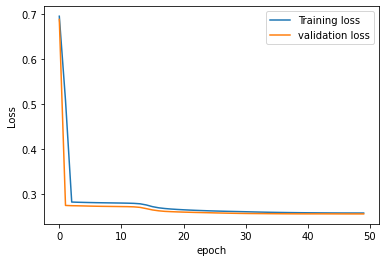

In [110]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### predict하는 코드

In [111]:
threshold = 0.5

In [112]:
pred_list = []
test_label = []

with torch.no_grad():
  net.eval()
  for batch_id, (vector, label) in enumerate(tqdm_notebook(test_dataloader)):
    vector = vector.to(device)
    label = label.long().to(device)
    test_label.extend(label)
    out = net(vector)
    out = torch.sigmoid(out)
    pred_list.extend(out.cpu().numpy())

pred_list = np.array([a.tolist() for a in pred_list])
test_label = np.array([a.squeeze().tolist() for a in test_label])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


###성능분석

In [113]:
thresholds = [0.38, 0.2, 0.26, 0.35, 0.2, 0.1, 0.15, 0.2, 0.1, 0.15, 0.08, 0.15, 0.1, 0.09, 0.1, 0.04, 0.02, 0.02]

In [114]:
acc = 0.0
for i in range(len(pred_list)) :
  sum = 0.0
  all = 0
  for j in range(18) :
    if pred_list[i][j] >= thresholds[j] :
      tmp = 1
    else :
      tmp = 0
    if tmp == 1 or test_label[i][j] == 1 :
      all += 1
    if test_label[i][j] == 1 and tmp == test_label[i][j] :
      sum += 1
  acc += sum / all
acc /= len(pred_list)
print('test acc : {}' .format(acc))

test acc : 0.1839949347126382


In [115]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, length):
    plt.plot(thresholds, precisions[:length], "b--", label='precision')
    plt.plot(thresholds, recalls[:length], "g-", label='recall')
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

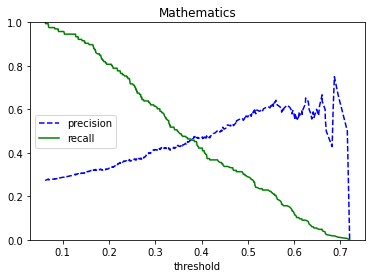

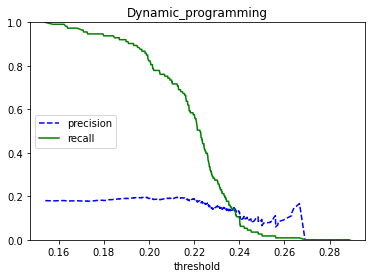

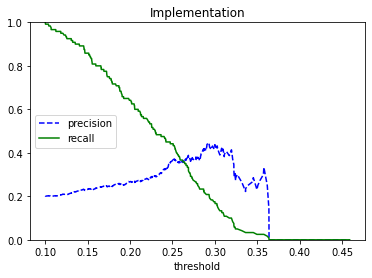

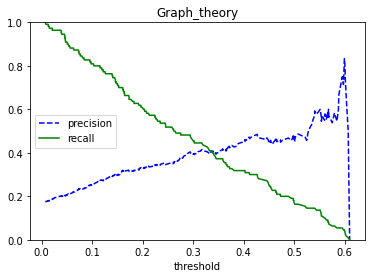

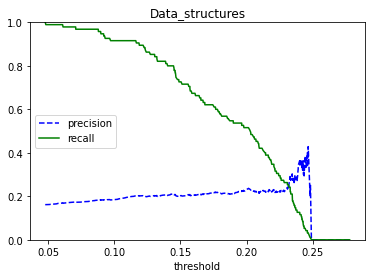

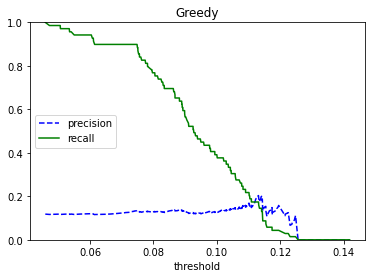

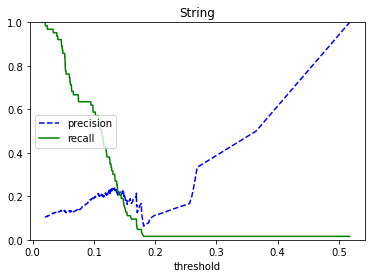

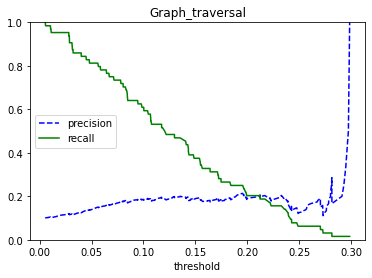

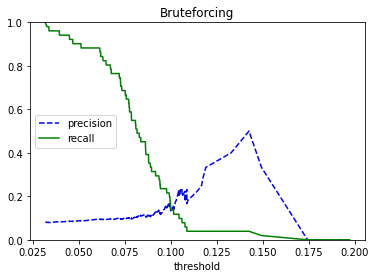

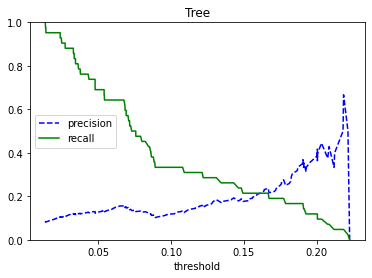

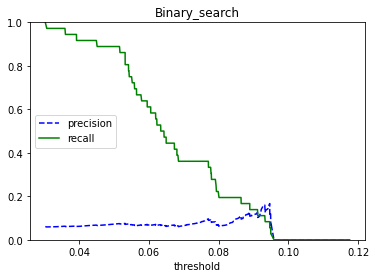

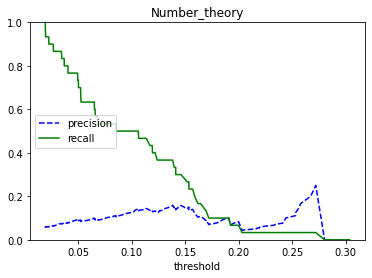

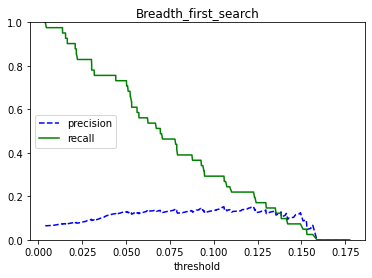

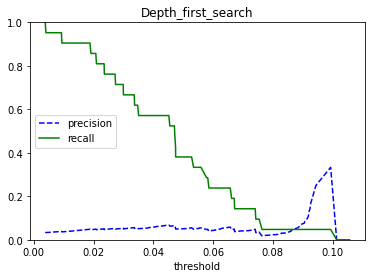

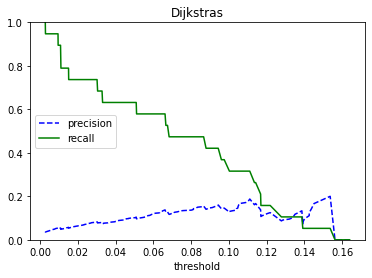

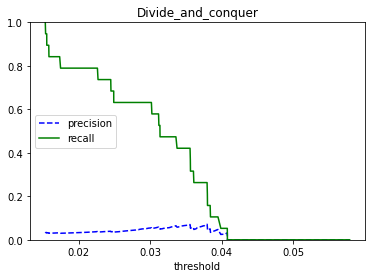

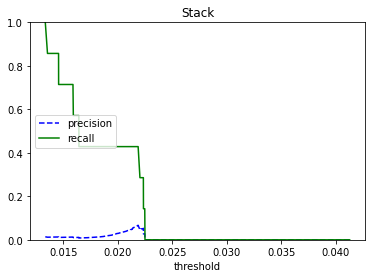

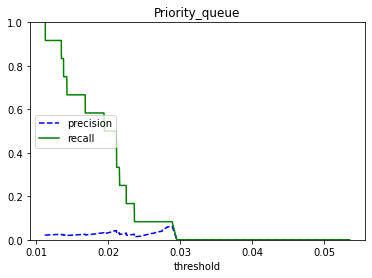

In [116]:
from sklearn.metrics import precision_recall_curve

for i in range(18) :
  y_scores = pred_list[:,i]
  y_true = test_label[:,i]
  precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
  plot_precision_recall_vs_threshold(precision, recall, thresholds, len(thresholds))
  plt.title(target_name[i])
  plt.show()

In [117]:
def draw_PR_graph(test_label, pred_list, i) :
  precision, recall, _ = precision_recall_curve(test_label, pred_list)

  ap = average_precision_score(test_label, pred_list)

  plt.title(target_name[i])
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  plt.plot(recall, precision, 'b', label = 'Classifier (AP = %0.2F)'%ap)   

  plt.legend(loc='upper right')
  plt.show()

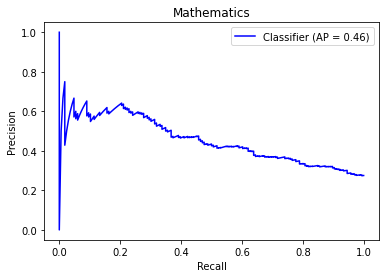

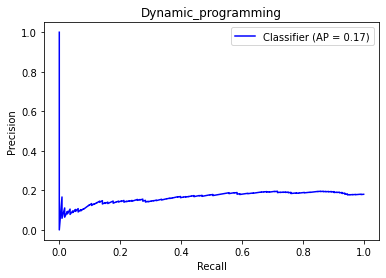

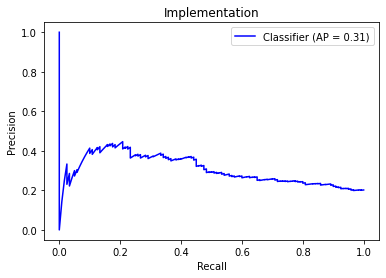

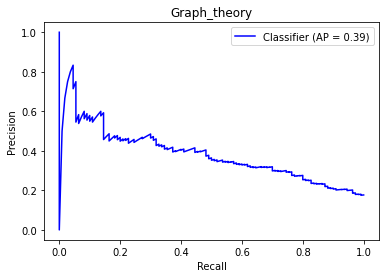

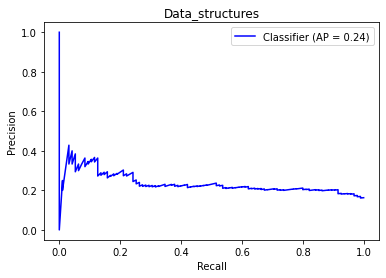

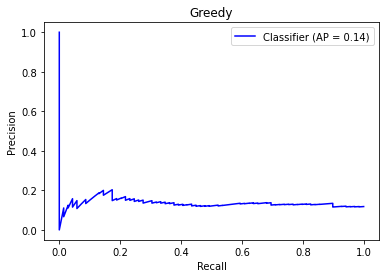

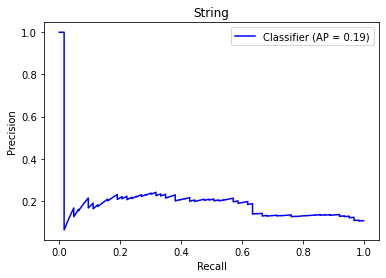

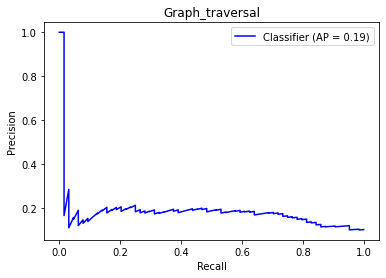

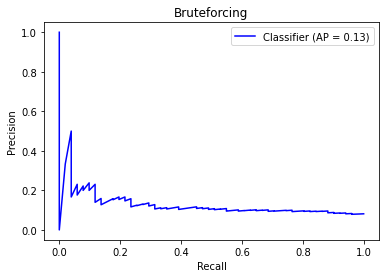

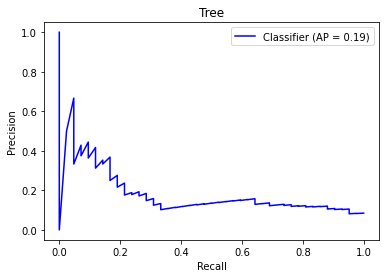

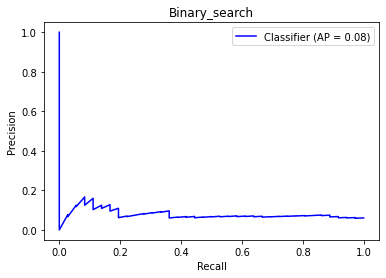

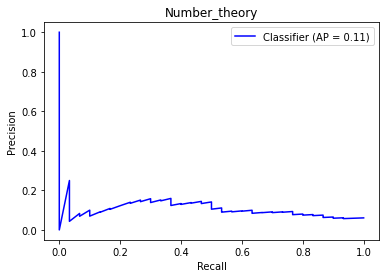

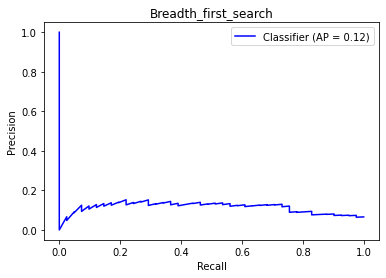

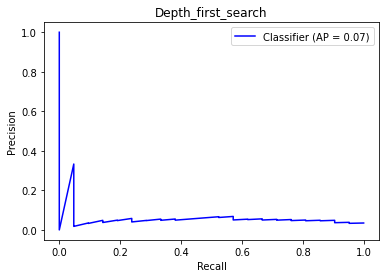

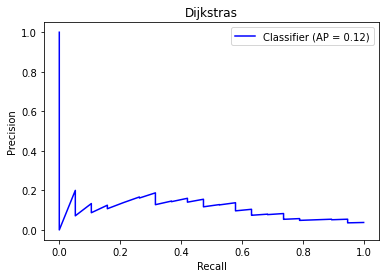

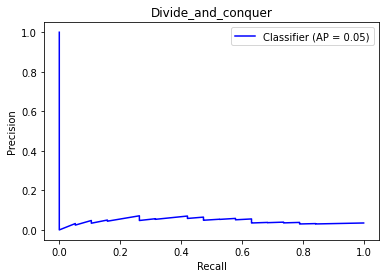

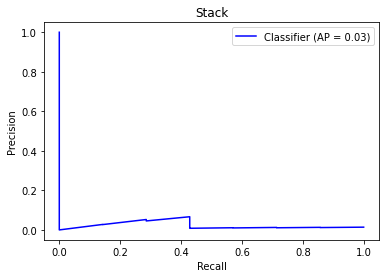

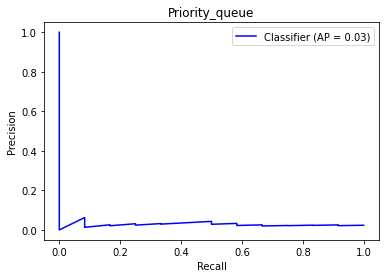

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

for i in range(18) :
  y_scores = pred_list[:,i]
  y_true = test_label[:,i]
  draw_PR_graph(y_true, y_scores, i)